In [ ]:
from os import listdir
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sys
from MRIDataset import SampleMapper, MRIDataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.optim as optim
import torch
import torchvision
import matplotlib.pyplot as plt

In [ ]:
# Construct patient list and related tumor grade
data_dir = "../data"
full_patient_list = []
for patient in listdir(data_dir):
    if "FU" in patient:
        continue
    full_patient_list.append(patient.replace("_nifti", ""))

tumor_grade = []
meta_data = pd.read_csv("../processed-data/UCSF-PDGM-metadata_v5.csv")
meta_data["ID"] = meta_data["ID"].apply(lambda x: "-".join(x.split("-")[:-1]) + "-" + x.split("-")[-1].rjust(4, "0"))
grade_key = "WHO CNS Grade"
for patient_id in full_patient_list:
    grade = meta_data[grade_key].loc[meta_data["ID"] == patient_id]
    tumor_grade.append(grade.values[0])
print(len(full_patient_list), len(tumor_grade))

495 495


In [ ]:
data_dir = "../processed-data/images"
modality = "FLAIR"
full_sample_map = SampleMapper(data_dir,
                               modality)

In [5]:
# Check that the splits are properly stratified with respect to tumor class.
train_patients, test_patients, train_tumor, test_tumor = train_test_split(full_patient_list, tumor_grade, test_size=0.2, random_state=360, stratify=tumor_grade)
print("N training patients:", len(train_patients))
print("N test patients:", len(test_patients))
print("N train tumor grade:", len(train_tumor))
classes, counts = np.unique(train_tumor, return_counts=True)
print("\tTraining tumor classes:", classes)
print("\tTraining tumor class proportion:", counts/counts.sum())
print("N test tumor grade:", len(test_tumor))
classes, counts = np.unique(test_tumor, return_counts=True)
print("\tTest tumor classes:", classes) 
print("\tTest tumor class proportion:", counts/counts.sum())

N training patients: 396
N test patients: 99
N train tumor grade: 396
	Training tumor classes: [2 3 4]
	Training tumor class proportion: [0.11363636 0.08585859 0.80050505]
N test tumor grade: 99
	Test tumor classes: [2 3 4]
	Test tumor class proportion: [0.11111111 0.09090909 0.7979798 ]


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, accuracy_score, roc_curve, PrecisionRecallDisplay, RocCurveDisplay

full_data_map = full_sample_map.data_map

## Separate the training data into 4 batches for 4Fold Cross validation.
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=360)

# DataLoader parameters
batch_size = 32

models = []
loss = {}
acc = {}


# Transforms to perform after PIL to tensor, resizing, and ToDType(float32) automatically performed by the dataset.
resnet_weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
preprocessing = resnet_weights.transforms()

each_split_precision = []
each_split_recall = []
each_split_tpr = [] # True positive rate
each_split_fpr = [] # False positive rate
each_split_auc = []
each_split_avg_precision = []
each_split_f1_by_threshold = []
each_split_pr_thresholds = []
each_split_accuracy_score = []

each_split_h_positive = []
each_split_h_negative = []
each_split_grade_2_h_positive = []
each_split_grade_2_h_negative = []
each_split_grade_3_h_positive = []
each_split_grade_3_h_negative = []
each_split_grade_4_h_positive = []
each_split_grade_4_h_negative = []



def f1_by_threshold(y_targets, y_prediction, thresholds):
    f1_scores_by_threshold = []
    for threshold in thresholds:
        preds_at_threshold = y_prediction >= threshold
        f1 = f1_score(y_targets, preds_at_threshold)
        f1_scores_by_threshold.append(f1)
    return f1_scores_by_threshold

# Models were trained on FLAIR input data.
model_param_path_template = "./models/model_fold{fold}_resnet_FLAIR.pth"

for i, (train_indices, validation_indices) in enumerate(skf.split(train_patients, train_tumor)):
    # Multiple slices are taken from the MRI of a single patient_id. 
    # Dataset indices for these slices are pulled from the get_indices_from_patient_list method.
    print("Currently running through fold", i)

    training_patients = np.array(train_patients)[train_indices]
    validation_patients = np.array(train_patients)[validation_indices]

    validation_tumor_grade = np.array(train_tumor)[validation_indices]
    validation_grade_2 = validation_patients[validation_tumor_grade == 2]
    validation_grade_3 = validation_patients[validation_tumor_grade == 3]
    validation_grade_4 = validation_patients[validation_tumor_grade == 4]

    training_data_map = full_data_map.loc[full_data_map["patient_id"].isin(training_patients)]
    validation_data_map = full_data_map.loc[full_data_map["patient_id"].isin(validation_patients)]

    grade_2_mask = validation_data_map["patient_id"].isin(validation_grade_2).to_numpy()
    grade_3_mask = validation_data_map["patient_id"].isin(validation_grade_3).to_numpy()
    grade_4_mask = validation_data_map["patient_id"].isin(validation_grade_4).to_numpy()


    print("Loading the validation dataset...")
    validation_dataset = MRIDataset(validation_data_map,
                                                   pre_transforms=[preprocessing],
                                                   to_rgb=True)
    print("N validation samples:" , len(validation_dataset))

    print("Building validation dataloader...")
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Use a resnet model
    model = torchvision.models.resnet18(weights=resnet_weights)
    model_fc_features = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(model_fc_features, 1024), nn.ReLU(), nn.Dropout(0.5), nn.Linear(1024,1), nn.Sigmoid())
    model_param_path = model_param_path_template.format(fold=i)
    model_params = torch.load(model_param_path, weights_only=True)
    model.load_state_dict(model_params)
    model.eval()

    validation_predictions = []
    validation_targets = []
    for images, labels in validation_loader:
        X = model.forward(images)
        validation_predictions = [*validation_predictions, *X.detach().numpy().flatten()]
        validation_targets = [*validation_targets, *labels.detach().numpy().flatten()]

    validation_predictions = np.array(validation_predictions).flatten()
    validation_targets = np.array(validation_targets).flatten()

    precision, recall, thresholds = precision_recall_curve(validation_targets, validation_predictions)
    f1_scores_by_threshold = f1_by_threshold(validation_targets, validation_predictions, thresholds)
    avg_precision = average_precision_score(validation_targets, validation_predictions)
    aucroc = roc_auc_score(validation_targets, validation_predictions)
    print("ROC AUC:", aucroc)
    print("Average Precision:", avg_precision)
    fpr, tpr, _ = roc_curve(validation_targets, validation_predictions)
    accuracy = accuracy_score(validation_targets, np.array(validation_predictions) > 0.5)

    each_split_precision.append(precision)
    each_split_recall.append(recall)
    each_split_tpr.append(tpr)
    each_split_fpr.append(fpr)
    each_split_auc.append(aucroc)
    each_split_avg_precision.append(avg_precision)
    each_split_f1_by_threshold.append(f1_scores_by_threshold)
    each_split_pr_thresholds.append(thresholds)
    each_split_accuracy_score.append(accuracy)

    positive_indices = np.where(np.array(validation_targets) == 1)[0] 
    negative_indices = np.where(np.array(validation_targets) == 0)[0]
    h_positive = np.histogram(np.array(validation_predictions[positive_indices]), bins=np.arange(0, 1.05, 0.05))
    h_negative = np.histogram(np.array(validation_predictions[negative_indices]), bins=np.arange(0, 1.05, 0.05))
    each_split_h_positive.append(h_positive)
    each_split_h_negative.append(h_negative)



    positive_indices = np.logical_and(np.array(validation_targets) == 1, grade_2_mask)
    negative_indices = np.logical_and(np.array(validation_targets) == 0, grade_2_mask)
    h_positive = np.histogram(np.array(validation_predictions[positive_indices]), bins=np.arange(0, 1.05, 0.05))
    h_negative = np.histogram(np.array(validation_predictions[negative_indices]), bins=np.arange(0, 1.05, 0.05))
    each_split_grade_2_h_positive.append(h_positive)
    each_split_grade_2_h_negative.append(h_negative)

    positive_indices = np.logical_and(np.array(validation_targets) == 1, grade_3_mask)
    negative_indices = np.logical_and(np.array(validation_targets) == 0, grade_3_mask)
    h_positive = np.histogram(np.array(validation_predictions[positive_indices]), bins=np.arange(0, 1.05, 0.05))
    h_negative = np.histogram(np.array(validation_predictions[negative_indices]), bins=np.arange(0, 1.05, 0.05))
    each_split_grade_3_h_positive.append(h_positive)
    each_split_grade_3_h_negative.append(h_negative)

    positive_indices = np.logical_and(np.array(validation_targets) == 1, grade_4_mask)
    negative_indices = np.logical_and(np.array(validation_targets) == 0, grade_4_mask)
    h_positive = np.histogram(np.array(validation_predictions[positive_indices]), bins=np.arange(0, 1.05, 0.05))
    h_negative = np.histogram(np.array(validation_predictions[negative_indices]), bins=np.arange(0, 1.05, 0.05))
    each_split_grade_4_h_positive.append(h_positive)
    each_split_grade_4_h_negative.append(h_negative)




Currently running through fold 0
Loading the validation dataset...
N validation samples: 2371
Building validation dataloader...
ROC AUC: 0.8712526789449866
Average Precision: 0.887704509097794
Currently running through fold 1
Loading the validation dataset...
N validation samples: 2376
Building validation dataloader...
ROC AUC: 0.8944934757224319
Average Precision: 0.9054538251997484
Currently running through fold 2
Loading the validation dataset...
N validation samples: 2376
Building validation dataloader...
ROC AUC: 0.8949164767767461
Average Precision: 0.9050548454819811
Currently running through fold 3
Loading the validation dataset...
N validation samples: 2375
Building validation dataloader...
ROC AUC: 0.8936195711680126
Average Precision: 0.9054754874028743


In [70]:
print(each_split_accuracy_score)

[0.7895402783635597, 0.7634680134680135, 0.8186026936026936, 0.8109473684210526]


0.7908496732026143
0.8218181818181818
0.8201790073230268
0.8164251207729468


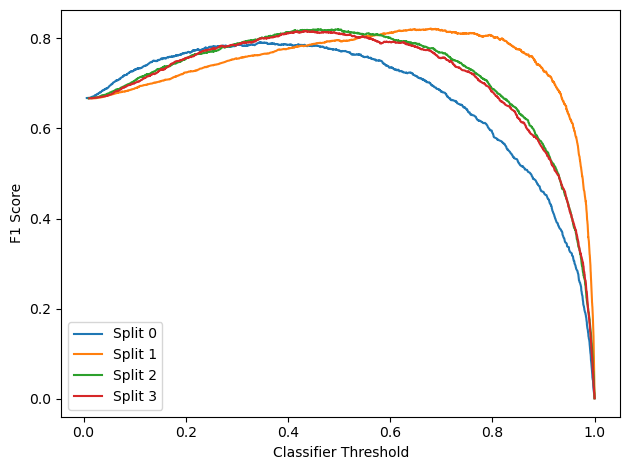

In [58]:
# Map F1 score with thresholds set by the pr curve
fig, ax = plt.subplots(1,1)
for i, split_f1 in enumerate(each_split_f1_by_threshold):
    threshold = each_split_pr_thresholds[i]
    print(np.max(split_f1))
    ax.plot(threshold, split_f1, label=f"Split {i}")
ax.legend()
ax.set_ylabel("F1 Score")
ax.set_xlabel("Classifier Threshold")
fig.tight_layout()
plt.show()

c:\Users\jacob\anaconda3\envs\fall_2025_brain_tumor_diagnosis\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


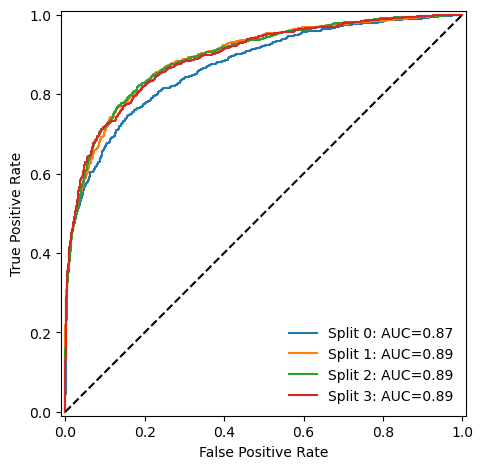

In [73]:
each_split_precision
each_split_recall
fig, ax = plt.subplots(1,1)
for i, split_fpr in enumerate(each_split_fpr):
    split_tpr = each_split_tpr[i]
    aucroc = each_split_auc[i]
    roc_display = RocCurveDisplay(fpr=split_fpr, tpr=split_tpr).plot(ax=ax, label=f"Split {i}: AUC={aucroc:.2f}")

ax.plot([0,1],[0,1], "k--")
ax.legend(frameon=False)
fig.tight_layout()
if not os.path.exists("./figures"):
    os.makedirs("./figures")
fig.savefig("./figures/resnet_ROC.png")
plt.show()

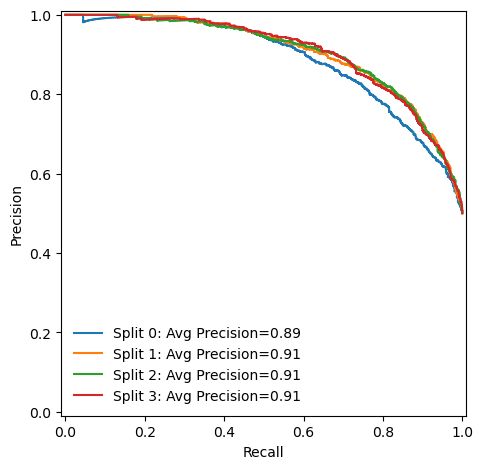

In [74]:
each_split_precision
each_split_recall
fig, ax = plt.subplots(1,1)
for i, split_precision in enumerate(each_split_precision):
    split_recall = each_split_recall[i]
    split_avg_precision = each_split_avg_precision[i]
    pr_display = PrecisionRecallDisplay(precision=split_precision, recall=split_recall).plot(ax=ax, label=f"Split {i}: Avg Precision={split_avg_precision:.2f}")

#ax.plot([0,1],[0,1], "k--")
ax.legend(frameon=False)
fig.tight_layout()
if not os.path.exists("./figures"):
    os.makedirs("./figures")
fig.savefig("./figures/resnet_PR_curve.png")
plt.show()

[0.01683502 0.03030303 0.03787879 0.0496633  0.0530303  0.04545455
 0.04208754 0.03787879 0.03535354 0.04882155 0.05218855 0.05808081
 0.0530303  0.07070707 0.07070707 0.08249158 0.07828283 0.07996633
 0.12037037 0.23989899]
[0.01094276 0.01683502 0.02525253 0.03619529 0.03535354 0.03198653
 0.03451178 0.03198653 0.03030303 0.03282828 0.03703704 0.0462963
 0.03872054 0.0530303  0.0547138  0.06060606 0.06397306 0.06060606
 0.10016835 0.1986532 ]
[0.         0.00420875 0.01010101 0.00673401 0.00925926 0.00925926
 0.01683502 0.01094276 0.01851852 0.01767677 0.02525253 0.02525253
 0.03030303 0.03619529 0.05639731 0.04882155 0.09427609 0.12457912
 0.17929293 0.5993266 ]
[0.         0.00420875 0.00841751 0.00673401 0.00673401 0.00673401
 0.01094276 0.00841751 0.01178451 0.01430976 0.02020202 0.01430976
 0.01936027 0.02861953 0.04040404 0.03872054 0.06649832 0.08838384
 0.13636364 0.46885522]
[0.003367   0.00673401 0.02104377 0.02356902 0.02609428 0.02693603
 0.03114478 0.03956229 0.04208754 

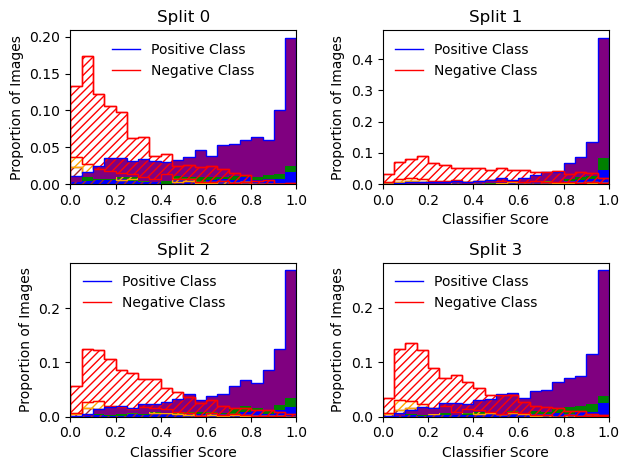

In [75]:
each_split_h_positive
each_split_h_negative
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flatten()):
    split_h_positive, bins = each_split_h_positive[i] 
    split_h_negative, _ = each_split_h_negative[i] 
    pos_norm = split_h_positive.sum()
    neg_norm = split_h_negative.sum()
    split_grade_2_h_positive = each_split_grade_2_h_positive[i][0] / pos_norm 
    split_grade_2_h_negative = each_split_grade_2_h_negative[i][0] / neg_norm
    split_grade_3_h_positive = each_split_grade_3_h_positive[i][0] / pos_norm + split_grade_2_h_positive
    split_grade_3_h_negative = each_split_grade_3_h_negative[i][0] / neg_norm + split_grade_2_h_negative
    split_grade_4_h_positive = each_split_grade_4_h_positive[i][0] / pos_norm + split_grade_3_h_positive
    split_grade_4_h_negative = each_split_grade_4_h_negative[i][0] / neg_norm + split_grade_3_h_negative
    edges = np.arange(0, 1.05, 0.05)
    print(split_grade_2_h_positive + split_grade_3_h_positive + split_grade_4_h_positive)
    print(split_h_positive / pos_norm)
    ax.stairs(split_grade_2_h_positive, edges=edges, baseline=0, color="b", fill=True)
    ax.stairs(split_grade_2_h_negative, edges=edges, baseline=0, color="brown", hatch="////")
    ax.stairs(split_grade_3_h_positive, edges=edges, baseline=split_grade_2_h_positive, color="g", fill=True)
    ax.stairs(split_grade_3_h_negative, edges=edges, baseline=split_grade_2_h_negative, color="orange", hatch="////")
    ax.stairs(split_grade_4_h_positive, edges=edges, baseline=split_grade_3_h_positive, color="purple", fill=True)
    ax.stairs(split_grade_4_h_negative, edges=edges, baseline=split_grade_3_h_negative, color="r", hatch="////")
    
    ax.stairs(split_h_positive/split_h_positive.sum(), edges=edges, color="b", label="Positive Class")
    ax.stairs(split_h_negative/split_h_negative.sum(), edges=edges, color="r", label="Negative Class")

    ax.set_xlim(0, 1.0)
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Proportion of Images")
    ax.set_xlabel("Classifier Score")
    ax.set_title(f"Split {i}")
    ax.legend(frameon=False)

fig.tight_layout()
if not os.path.exists("./figures"):
    os.makedirs("./figures")
fig.savefig("./figures/resnet_Score_Distribution.png")

In [ ]:
# Summaries on test set with Split 2
threshold = 0.5
split=2

# Load model and dataset
resnet_weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
preprocessing = resnet_weights.transforms()
model = torchvision.models.resnet18(weights=resnet_weights)
model_fc_features = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(model_fc_features, 1024), nn.ReLU(), nn.Dropout(0.5), nn.Linear(1024,1), nn.Sigmoid())
model_param_path = model_param_path_template.format(fold=split)
model_params = torch.load(model_param_path, weights_only=True)
model.load_state_dict(model_params)
model.eval()


test_patients = np.array(test_patients)
test_data_map = full_data_map.loc[full_data_map["patient_id"].isin(test_patients)]


print("Loading the validation dataset...")
test_dataset = MRIDataset(test_data_map,
                                         pre_transforms=[preprocessing],
                                         to_rgb=True)
print("N validation samples:" , len(test_dataset))

print("Building validation dataloader...")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_predictions = []
test_targets = []
for images, labels in test_loader:
    X = model.forward(images)
    test_predictions = [*test_predictions, *X.detach().numpy().flatten()]
    test_targets = [*test_targets, *labels.detach().numpy().flatten()]


precision, recall, thresholds = precision_recall_curve(validation_targets, validation_predictions)
f1_scores_by_threshold = f1_by_threshold(validation_targets, validation_predictions, thresholds)
avg_precision = average_precision_score(validation_targets, validation_predictions)
aucroc = roc_auc_score(validation_targets, validation_predictions)
print("ROC AUC:", aucroc)
print("Average Precision:", avg_precision)
fpr, tpr, _ = roc_curve(validation_targets, validation_predictions)

Loading the validation dataset...
N validation samples: 2373
Building validation dataloader...
ROC AUC: 0.8936195711680126
Average Precision: 0.9054754874028743


In [72]:
accuracy_score(test_targets, np.array(test_predictions) > 0.5)

0.8006742520016856

0.45526466


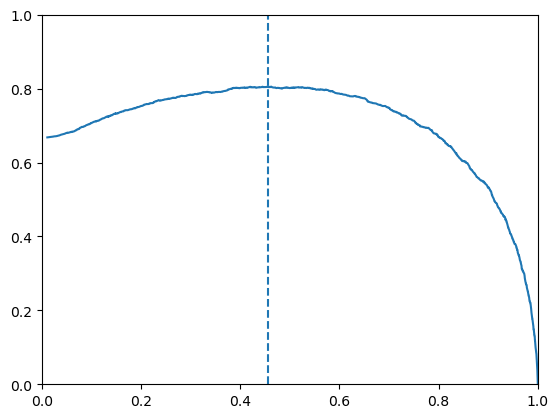

In [34]:
test_f1_scores = f1_by_threshold(test_targets, test_predictions, thresholds)
max_index = np.where(np.array(test_f1_scores) == np.max(test_f1_scores))[0][-1]
max_threshold = thresholds[max_index]
print(max_threshold)
plt.plot(thresholds, test_f1_scores)
plt.vlines([max_threshold], 0, 1, linestyles="--")
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

[<Axes: > <Axes: >]


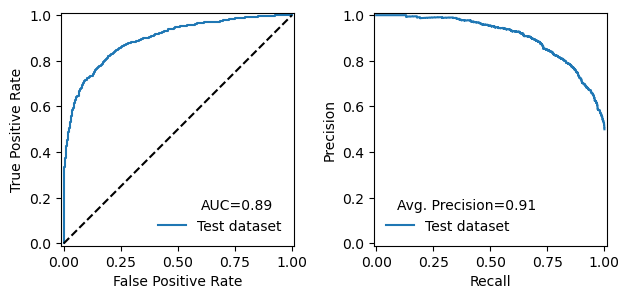

In [76]:
fig, axes = plt.subplots(1,2)
print(axes)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[0], label=f"Test dataset")
axes[0].plot([0,1],[0,1], "k--")
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=axes[1], label=f"Test dataset")
axes[0].annotate(f'AUC={aucroc:.2f}', xy=(0.6, 0.2), xycoords='axes fraction',
                 size=10, ha='left', va='top')
axes[1].annotate(f'Avg. Precision={avg_precision:.2f}', xy=(0.1, 0.2), xycoords='axes fraction',
                 size=10, ha='left', va='top')
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
fig.tight_layout()
if not os.path.exists("./figures"):
    os.makedirs("./figures")
fig.savefig("./figures/resnet_TEST_ROC_PR.png")
plt.show()

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(test_targets, np.array(test_predictions) > 0.5)

0.8006742520016856